In [1]:
# 패키지 불러오기
require(ggplot2)
require(repr)
options(repr.plot.width=5, repr.plot.height=3)

Loading required package: ggplot2
Loading required package: repr


In [2]:
# 삭제
rm(list = ls())

In [3]:
## Term Structure Class 정의

# Smith-Wilson Class
setClass('Smith.Wilson',
        representation(alpha="numeric", UFR="numeric", terms="numeric", int="numeric", zeta="numeric"))

# Wilson function
setGeneric("Wilson", function(object, ...) standardGeneric("Wilson"))
setMethod("Wilson", "Smith.Wilson", Vectorize(function(object,t,u,order=0){
    if (order==0) {
        y <- exp(-object@UFR*(t+u))*(object@alpha*pmin(t,u) - 0.5*exp(-object@alpha*pmax(t,u))*(exp(object@alpha*pmin(t,u)) - exp(-object@alpha*pmin(t,u))))
    }else if(order==1){
        if (t < u) y <- exp(-object@UFR*t-(object@alpha+object@UFR)*u)*(object@UFR*sinh(object@alpha*t)-object@alpha*cosh(object@alpha*t)-object@alpha*(object@UFR*t-1)*exp(object@alpha*u))
        else y <- exp(-object@UFR*u-(object@alpha+object@UFR)*t)*((object@alpha+object@UFR)*sinh(object@alpha*u)-object@alpha*object@UFR*u*exp(object@alpha*t))
    }else if(order==2){
        if (t < u) y <- exp(-object@UFR*t-(object@alpha+object@UFR)*u)*(-(object@alpha^2+object@UFR^2)*sinh(object@alpha*t)+2*object@alpha*object@UFR*cosh(object@alpha*t)+object@alpha*object@UFR*(object@UFR*t-2)*exp(object@alpha*u)) 
        else y <- exp(-object@UFR*u-(object@alpha+object@UFR)*t)*(object@alpha*object@UFR^2*u*exp(object@alpha*t)-(object@alpha+object@UFR)^2*sinh(object@alpha*u))
    }else print('유효한 order가 아닙니다.')
    return(y)
}, vectorize.args=c('t','u')))
         
# Term Structure
setGeneric("TermStr", function(object, ...) standardGeneric("TermStr"))
setMethod("TermStr", "Smith.Wilson", function(object, t){
    y <- (1/Bond(object,t))^(1/t) - 1
    return(y)
})

# Forward Rate
setGeneric("Forward", function(object, ...) standardGeneric("Forward"))
setMethod("Forward", "Smith.Wilson", Vectorize(function(object, t, order=0){
    if (order==0) y <- -Bond(object,t,1)/Bond(object,t,0)
    else if (order==1) y <- 1/Bond(object,t,0)*(-Bond(object,t,1)^2/Bond(object,t,0) + Bond(object,t,2))
    else print('유효한 order가 아닙니다.')
    return(y)
}, vectorize.args='t'))
        
# Bond Price
setGeneric("Bond", function(object, ...) standardGeneric("Bond"))
setMethod("Bond", "Smith.Wilson", Vectorize(function(object, t, order=0){
    y <- (-object@UFR)^order*exp(-object@UFR*t) + object@zeta %*% Wilson(object, t, object@terms, order)
    return(y)
}, vectorize.args="t"))
    
# Calibration
setGeneric("Calibration", function(object, ...) standardGeneric("Calibration"))
setMethod("Calibration", "Smith.Wilson", function(object, alpha,tol=0.0001, M=60){
    obj <- function(alpha){
        object <- initialize(object,alpha=alpha,UFR=object@UFR,terms=object@terms,int=object@int)
        error <- sqrt((tol-abs(Forward(object,M)-object@UFR))^2)
        return(error)
    }

    alpha <- optimize(obj, interval=c(0,1))$minimum
    return(alpha)
})

# Initialize
setMethod("initialize", "Smith.Wilson", function(.Object, alpha, UFR, terms, int){
    .Object@alpha <- alpha
    .Object@UFR <- UFR
    .Object@terms <- terms
    .Object@int <- int
    
    W <- outer(terms, terms, FUN=function(x,y) Wilson(.Object, x, y))
    m  <- 1/(1+int)^terms
    mu <- exp(-UFR*terms)
    .Object@zeta <- as.numeric((m-mu)%*%solve(W))
    
    return(.Object)
})

[1] "Wilson"

[1] "Wilson"

[1] "TermStr"

[1] "TermStr"

[1] "Forward"

[1] "Forward"

[1] "Bond"

[1] "Bond"

[1] "Calibration"

[1] "Calibration"

[1] "initialize"

In [4]:
# 입력 데이터
int.rate <- c(0.0334,0.0326,0.0327,0.0328,0.033,0.0335,0.0342,0.0345,0.0347,0.0352)
int.mat <- c(1,2,3,4,5,7,10,12,15,20)
vol <- matrix (c(0.1815,0.172,0.17,0.1605,0.158,0.155,
                 0.177,0.1715,0.17,0.158,0.1545,0.15,
                 0.174,0.168,0.1655,0.1555,0.1495,0.1475,
                 0.165,0.1575,0.157,0.1495,0.1455,0.144,
                 0.165,0.1575,0.157,0.1535,0.1455,0.144,
                 0.1665,0.159,0.1575,0.15,0.1455,0.14),
                 ncol=6, byrow=TRUE)
colnames(vol) <- rownames(vol) <- tenor <- c(1,2,3,5,7,10)

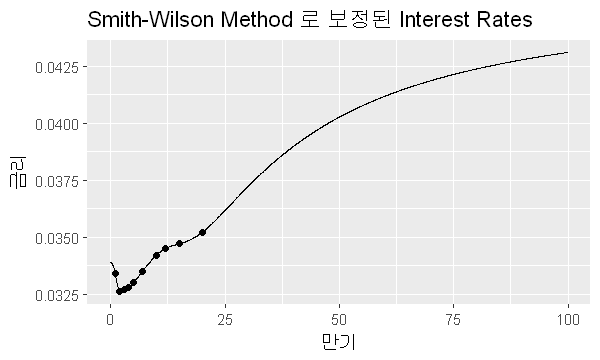

In [5]:
# Smith-Wilson 객체 생성
sw <- new("Smith.Wilson", alpha=0.1, UFR=0.045, terms=int.mat, int=int.rate)

# 보정된 금리 생성
t <- seq(0.01,100,by=0.05)
int.rate.sw <- TermStr(sw, t)
    
# 그래프 출력
ggplot() +
    geom_line(aes(x=t, y=int.rate.sw)) +
    geom_point(aes(x=int.mat, y=int.rate)) +
    labs(x='만기', y='금리', title='Smith-Wilson Method 로 보정된 Interest Rates')

In [6]:
setGeneric("Vol", function(object, ...) standardGeneric("Vol"))
setGeneric("A", function(object, ...) standardGeneric("A"))
setGeneric("B", function(object, ...) standardGeneric("B"))
setGeneric("fswap", function(object, ...) standardGeneric("fswap"))
setGeneric("fswap.cf", function(object, ...) standardGeneric("fswap.cf"))
setGeneric("Jamshidian", function(object, ...) standardGeneric("Jamshidian"))
setGeneric("ReceiverSwaption", function(object, ...) standardGeneric("ReceiverSwaption"))
setGeneric("Objective", function(object, ...) standardGeneric("Objective"))

[1] "Vol"

[1] "A"

[1] "B"

[1] "fswap"

[1] "fswap.cf"

[1] "Jamshidian"

[1] "ReceiverSwaption"

[1] "Objective"

In [7]:
# Hull-White Class 정의
setClass('Hull.White',
        representation(alpha="numeric", sigma="numeric", termStr='Smith.Wilson', fswap.vol='matrix', fswap.tenor='numeric', fswap.rate='matrix', rs.black='matrix', N='numeric', tau='numeric'))

# Bond Price
setMethod("Bond", "Hull.White", function(object,t,T,r,order=0){
    if (order==0) y <- A(object,t,T)*exp(-B(object,t,T)*r)
    else if(order==1) y <- -B(object,t,T)*Bond(object,t,T,r)
    return(y)
})

# Volatility
setMethod("Vol", "Hull.White", function(object,T,S){
    y <- object@sigma/object@alpha*(1-exp(-object@alpha*(S-T)))*sqrt((1-exp(-2*object@alpha*T))/(2*object@alpha))
    return(y)
})

# A(t,T)
setMethod("A", "Hull.White", function(object,t,T){
    y <- Bond(object@termStr,T)/Bond(object@termStr,t)*exp(B(object,t,T)*Forward(object@termStr, t) - object@sigma^2/(4*object@alpha)*B(object,t,T)^2*(1-exp(-2*object@alpha*t)))
    return(y)
})
 
# B(t,T)
setMethod("B", "Hull.White", function(object,t,T){
    y <- (1-exp(-object@alpha*(T-t)))/object@alpha
    return(y)
})

# Forward Swap Rate
setMethod("fswap", "Hull.White", Vectorize(function(object,T,S, tau=0.25){
    (Bond(object@termStr, T)-Bond(object@termStr, S))/(tau*sum(Bond(object@termStr, seq(T+tau,S,tau))))
}, vectorize.args = c('T','S')))

# Forward Swap Rate Cash flow
setMethod("fswap.cf", "Hull.White", function(object,T,S,tau=object@tau){
    c <- rep(fswap(object,T,S)*object@tau,(S-T)/tau)
    c[(S-T)/tau] <- 1+c[(S-T)/tau]
    return(c)
})

# Jamshidian's Trick
setMethod("Jamshidian", "Hull.White", Vectorize(function(object,T,S,tau=object@tau){
    #r = optimize(function(r) abs(sum(fswap.cf(object,T,S)*Bond(object, T, seq(T+tau, S, by=tau), r=r))-1), interval=c(0,1))$minimum
    T.i <- seq(T+tau,S,by=tau)
    f <- function(r) (sum(fswap.cf(object,T,S)*Bond(object,T,T.i,r=r))-1)^2
    grad <- function(r) 2*(sum(fswap.cf(object,T,S)*Bond(object,T,T.i,r=r))-1)*sum(fswap.cf(object,T,S)*Bond(object,T,T.i,r=r,order=1))
    r <- optim(0.03, f, grad, method='Brent', lower=0.01, upper=0.05)$par
    return(r)
}, vectorize.args=c("T","S")))

# Hull-White Swaption
setMethod("ReceiverSwaption", "Hull.White", Vectorize(function(object,T,S,tau=object@tau){
    r <- Jamshidian(object,T,S)
    T.i <- seq(T+tau, S, by=tau)
    X <- Bond(object, T, T.i, r)
    di.pos <- 1/Vol(object, T=T,S=T.i)*log(Bond(object, t=0,T=T.i,r=r)/Bond(object,t=0,T=T,r=r)/X) + Vol(object,T=T,S=T.i)/2
    di.neg <- di.pos - Vol(object,T=T,S=T.i)
    y <- object@N*sum(fswap.cf(object,T=T,S=S,tau=tau)*(Bond(object,t=0,T=T.i,r=r)*pnorm(di.pos) - X*Bond(object,t=0,T=T,r=r)*pnorm(di.neg)))
    return(y)
}, vectorize.args=c("T","S")))     
    
# Objective Function
setMethod("Objective", "Hull.White", Vectorize(function(object,alpha,sigma){
    object@alpha <- alpha
    object@sigma <- sigma
    #obj <- sqrt(sum((ReceiverSwaption(object,rev(tenor),tenor+rev(tenor))-diag(object@rs.black[length(object@fswap.tenor):1,]))^2))
    #obj <- sum(((ReceiverSwaption(object,rev(tenor),tenor+rev(tenor))-diag(object@rs.black[length(object@fswap.tenor):1,]))/diag(object@rs.black[length(object@fswap.tenor):1,]))^2)
    #obj <- sum(((ReceiverSwaption(object,tenor,tenor+tenor)-diag(object@rs.black))/diag(object@rs.black))^2)
    obj <- sum(((outer(tenor,tenor, FUN=function(x,y) ReceiverSwaption(object,x,x+y)) - object@rs.black)/object@rs.black)^2)
    return(obj)
},vectorize.args=c("alpha","sigma")))    

# 객체 초기화
setMethod("initialize", "Hull.White", function(.Object, alpha, sigma, termStr, fswap.vol, fswap.tenor, tau=0.25, N=100){
    .Object@alpha <- alpha
    .Object@sigma <- sigma
    .Object@termStr <- termStr
    colnames(fswap.vol) <- rownames(fswap.vol) <- fswap.tenor
    .Object@fswap.vol <- fswap.vol
    .Object@fswap.tenor <- fswap.tenor
    # 0 < tau or tau > 1 이면 Raise Error
    .Object@tau <- tau
    .Object@N <- N
    
    fswap.rate <- outer(fswap.tenor, fswap.tenor, function(T,S) fswap(.Object,T,T+S,tau))
    rownames(fswap.rate) <- fswap.tenor
    colnames(fswap.rate) <- fswap.tenor
    .Object@fswap.rate <- fswap.rate   
        
    # Black Swaption
    price.alpha <- outer(fswap.tenor, fswap.tenor, FUN=function(x,y) Bond(termStr, x))
    price.beta <- outer(fswap.tenor, fswap.tenor, FUN=function(x,y) Bond(termStr, x+y))
    d1 <- 0.5*fswap.vol*sqrt(fswap.tenor)
    .Object@rs.black <- N*(price.alpha - price.beta)*(2*pnorm(d1, mean=0, sd=1)-1)
    
    return(.Object)
})

[1] "Bond"

[1] "Vol"

[1] "A"

[1] "B"

[1] "fswap"

[1] "fswap.cf"

[1] "Jamshidian"

[1] "ReceiverSwaption"

[1] "Objective"

[1] "initialize"

In [8]:
vol <- matrix(c(0.1815,0.172,0.17,0.1605,0.158,0.155,
                0.177,0.1715,0.17,0.158,0.1545,0.15,
                0.174,0.168,0.1655,0.1555,0.1495,0.1475,
                0.165,0.1575,0.157,0.1495,0.1455,0.144,
                0.165,0.1575,0.157,0.1535,0.1455,0.144,
                0.1665,0.159,0.1575,0.15,0.1455,0.1404),
                ncol=6, byrow=TRUE)
tenor <- c(1,2,3,5,7,10)

In [31]:
(hw <- new("Hull.White", alpha=0.05, sigma=0.006, termStr=sw, fswap.vol=vol, fswap.tenor=tenor))

An object of class "Hull.White"
Slot "alpha":
[1] 0.05

Slot "sigma":
[1] 0.006

Slot "termStr":
An object of class "Smith.Wilson"
Slot "alpha":
[1] 0.1

Slot "UFR":
[1] 0.045

Slot "terms":
 [1]  1  2  3  4  5  7 10 12 15 20

Slot "int":
 [1] 0.0334 0.0326 0.0327 0.0328 0.0330 0.0335 0.0342 0.0345 0.0347 0.0352

Slot "zeta":
 [1] -9.18030256  9.51096544 -5.48318480  2.51366839 -0.49645201  0.21756278
 [7]  0.09699988 -0.82931680  0.20325161  0.62624490


Slot "fswap.vol":
        1      2      3      5      7     10
1  0.1815 0.1720 0.1700 0.1605 0.1580 0.1550
2  0.1770 0.1715 0.1700 0.1580 0.1545 0.1500
3  0.1740 0.1680 0.1655 0.1555 0.1495 0.1475
5  0.1650 0.1575 0.1570 0.1495 0.1455 0.1440
7  0.1650 0.1575 0.1570 0.1535 0.1455 0.1440
10 0.1665 0.1590 0.1575 0.1500 0.1455 0.1404

Slot "fswap.tenor":
[1]  1  2  3  5  7 10

Slot "fswap.rate":
            1          2          3          5          7         10
1  0.03142883 0.03195556 0.03219457 0.03276692 0.03330565 0.03389771
2  0.0

In [ ]:
# Global
# alpha = 3.75e-1, sigma = 1.82e-2
(p <- constrOptim(c(0.0112067427660259,0.00501016828438452), function(p) Objective(hw,p[1],p[2]), grad=NULL, ui = matrix(c(1,-1,0,0,0,0,1,-1),nrow=4), ci = c(0.0e-1,-3.0e-2,0.0e-2,-1.0e-2))$par)

In [ ]:
# Local
hw@alpha <- 0.0279
(sigma <- optimize(function(sigma) Objective(hw,hw@alpha,sigma), interval=c(0,0.1))$minimum)

In [44]:
hw@alpha <- 0.01097536
hw@sigma <- 0.00501672
outer(tenor,tenor,function (x,y) ReceiverSwaption(hw, x,x+y))

0.2658720,0.5222361,0.7693146,1.235808,1.666426,2.249811
0.3427374,0.6739700,0.9937476,1.599286,2.160748,2.926880
0.3392434,0.6673688,0.9843968,1.585607,2.144545,2.911013
0.3540762,0.6969878,1.0288025,1.659941,2.250141,3.065921
0.3489206,0.6872014,1.0150322,1.640645,2.228899,3.043749
0.3518486,0.6938761,1.0264621,1.664260,2.265903,3.099537
